In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
aa = pd.read_csv('attribution_allocation_student_data.csv')
print(aa.shape)

(68124, 7)


In [3]:
aa.head(2)

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier
0,True,email,referral,referral,NaN,NaN,1
1,True,referral,referral,email,NaN,NaN,1


In [4]:
# deal with missing values
aa.fillna(0, inplace = True)
print(aa.head(2))

   convert_TF    touch1    touch2    touch3 touch4 touch5  tier
0        True     email  referral  referral      0      0     1
1        True  referral  referral     email      0      0     1


In [5]:
aa.convert_TF.describe()

count     68124
unique        2
top       False
freq      54345
Name: convert_TF, dtype: object

In [6]:
# filter the dataframe by the value of'convert_TF' == True
indices = aa['convert_TF'] == True
con = aa.loc[indices,:]
print(type(con))

<class 'pandas.core.frame.DataFrame'>


In [7]:
# rename the convert_TF column
con.rename(columns = {'convert_TF': 'convert_T'}, inplace = True)

C:\Users\21024\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
con.convert_T.describe()

count     13779
unique        1
top        True
freq      13779
Name: convert_T, dtype: object

In [9]:
con.tier.unique()

array([1, 2, 3], dtype=int64)

In [10]:
# extract new dataframe for tier1, tier2, tier3
indices = con.tier == 1
tier1 = con.loc[indices,:]
indices = con.tier == 2
tier2 = con.loc[indices,:]   
indices = con.tier == 3
tier3 = con.loc[indices,:]

In [11]:
print(tier1.shape)
print(tier2.shape)
print(tier3.shape)

(2824, 7)
(4892, 7)
(6063, 7)


In [12]:
# print(aa[aa.tier == 1].shape)
# print(aa[aa.tier == 2].shape)
# print(aa[aa.tier == 3].shape)

In [13]:
# x = [2824, 4892, 6063]
# y = [11354, 22708, 34062]
# con_rate = []
# for i in range(3):
#     con_rate.append(round(x[i]/y[i],2))
# con_rate

In [14]:
# # create a table to describe the convertion rate of each tier
# convertion_rate = pd.DataFrame(con_rate, index = ['tier1', 'tier2', 'tier3'], columns = ['convertion_rate'])
# convertion_rate

In [15]:
tier3.head(2)

,convert_T,touch1,touch2,touch3,touch4,touch5,tier
34062,True,referral,email,0,0,0,3
34063,True,referral,referral,email,0,0,3


In [16]:
# create a function to return a list of touches
def touch_list(df):
    touch = df[df.columns[1:6]].values.tolist()
    return touch     

In [17]:
t1_touch = touch_list(tier1)
t2_touch = touch_list(tier2)
t3_touch = touch_list(tier3)

In [18]:
#pip install demjson

In [19]:
# read the channel_spend file
import demjson
spend = pd.read_csv('channel_spend_student_data.csv', index_col = 0)
s_lst  = spend.values.tolist()
s_df = pd.DataFrame([demjson.decode(s_lst[0][0])])
for i in range(1, len(s_lst)):
    n_df = pd.DataFrame([demjson.decode(s_lst[i][0])])
    s_df = s_df.append(n_df, ignore_index = True)   
s_df

,email,social,display,paid_search,referral,organic_search,direct
0,1000.0,1000.0000000000001,1000.0,1000.0,1000.0,0.0,0.0
1,2000.0,2000,2000.0,2000.0,2000.0,0.0,0.0
2,3000.0,3000,3000.0,3000.0,3000.0,0.0,0.0


In [20]:
s_df.loc[0,'social'] = 1000

In [21]:
s_df.rename(index = {0:'tier1', 1:'tier2', 2:'tier3'}, inplace = True)
s_df

,email,social,display,paid_search,referral,organic_search,direct
tier1,1000.0,1000,1000.0,1000.0,1000.0,0.0,0.0
tier2,2000.0,2000,2000.0,2000.0,2000.0,0.0,0.0
tier3,3000.0,3000,3000.0,3000.0,3000.0,0.0,0.0


In [22]:
s_df.loc['tier1', 'email']

1000.0

# Part 1, attribution 

## 1.1 Test 3 methods for allocation

### 1.1.1 Last interaction

In [23]:
def last_interaction(touch_lst):
    '''
    This function returns the count of each channel under the last interaction allocation method
    '''
    count_dict = {}
    for i in range(len(touch_lst)):
        for x in range(4,-1, -1):
            if touch_lst[i][x] != 0:
                if touch_lst[i][x] not in count_dict:
                    count_dict[touch_lst[i][x]] = 1
                else:
                    count_dict[touch_lst[i][x]] += 1
                break
    return count_dict

In [24]:
tier1_count = last_interaction(t1_touch)
tier2_count = last_interaction(t2_touch)
tier3_count = last_interaction(t3_touch)

In [25]:
tier1_count

{'referral': 1187,
 'email': 299,
 'social': 622,
 'display': 531,
 'paid_search': 180,
 'organic_search': 2,
 'direct': 3}

In [26]:
def cal_cac(count_touch_dict, group, df):
    '''
    This function calculates the average CAC of each channel in a tier
    '''
    cac_dict = {}
    for k, v in count_touch_dict.items():
        cac_dict[k] = round(df.loc[group, k]/v, 2) # round values to 2 decimals
    return pd.DataFrame([cac_dict])


In [27]:
tier1_cac = cal_cac(count_touch_dict = tier1_count, group = 'tier1',df = s_df)
tier1_cac

,referral,email,social,display,paid_search,organic_search,direct
0,0.84,3.34,1.61,1.88,5.56,0.0,0.0


In [28]:
tier2_cac = cal_cac(count_touch_dict = tier2_count, group = 'tier2',df = s_df)
tier2_cac

,email,display,referral,social,paid_search,organic_search
0,3.76,2.43,0.94,1.87,5.88,0.0


In [29]:
tier3_cac = cal_cac(count_touch_dict = tier3_count, group = 'tier3',df = s_df)
tier3_cac

,email,paid_search,referral,social,display,direct,organic_search
0,4.37,6.2,1.12,2.39,3.13,0.0,0.0


In [30]:
frames = [tier1_cac, tier2_cac, tier3_cac]
last_result = pd.concat(frames, keys=['tier1', 'tier2', 'tier3'])

In [31]:
last_result

,,referral,email,social,display,paid_search,organic_search,direct
tier1,0,0.84,3.34,1.61,1.88,5.56,0.0,0.0
tier2,0,0.94,3.76,1.87,2.43,5.88,0.0,NaN
tier3,0,1.12,4.37,2.39,3.13,6.20,0.0,0.0


### 1.1.2 linear model

In [32]:
def linear_model(touch_lst):
    '''
    This function returns the count of each channel under the linear model allocation method
    '''
    count_dict = {}
    for i in range(len(touch_lst)):
        # count the number of element which is not euqal to 0
        length = 5- touch_lst[i].count(0)
        ratio = 1/length
        for x in range(5):
            if touch_lst[i][x] != 0:
                if touch_lst[i][x] not in count_dict:
                    count_dict[touch_lst[i][x]] = 1*ratio
                else:
                    count_dict[touch_lst[i][x]] += 1*ratio
    return count_dict

In [33]:
tier1_count_lm = linear_model(t1_touch)
tier2_count_lm = linear_model(t2_touch)
tier3_count_lm = linear_model(t3_touch)

In [34]:
tier1_count_lm

{'email': 243.666666666667,
 'referral': 1503.1166666666657,
 'social': 479.0166666666614,
 'display': 466.43333333332856,
 'paid_search': 127.16666666666646,
 'direct': 2.25,
 'organic_search': 2.35}

In [35]:
tier1_cac_lm = cal_cac(count_touch_dict = tier1_count_lm, group = 'tier1',df = s_df)
tier1_cac_lm

,email,referral,social,display,paid_search,direct,organic_search
0,4.1,0.67,2.09,2.14,7.86,0.0,0.0


In [36]:
tier2_cac_lm = cal_cac(count_touch_dict = tier2_count_lm, group = 'tier2',df = s_df)
tier2_cac_lm

,referral,email,display,social,paid_search,organic_search,direct
0,0.75,4.77,2.8,2.43,8.11,0.0,0.0


In [37]:
tier3_cac_lm = cal_cac(count_touch_dict = tier3_count_lm, group = 'tier3',df = s_df)
tier3_cac_lm

,referral,email,display,paid_search,social,direct,organic_search
0,0.91,5.04,3.53,8.98,3.04,0.0,0.0


In [38]:
frames_lm = [tier1_cac_lm, tier2_cac_lm, tier3_cac_lm]
last_result_lm = pd.concat(frames_lm, keys=['tier1', 'tier2', 'tier3'])

In [39]:
last_result_lm

,,email,referral,social,display,paid_search,direct,organic_search
tier1,0,4.10,0.67,2.09,2.14,7.86,0.0,0.0
tier2,0,4.77,0.75,2.43,2.80,8.11,0.0,0.0
tier3,0,5.04,0.91,3.04,3.53,8.98,0.0,0.0


### 1.1.3 Position based

In [40]:
def position_based(touch_lst):
    '''
    This function returns the count of each channel under the position based allocation method
    '''
    count_dict = {}
    for i in range(len(touch_lst)):
        length = 5- touch_lst[i].count(0)
        if length >=3:
            ratio = 1/(length-2)
            position = []
            # first position
            for x in range(5):
                if touch_lst[i][x] != 0:
                    position.append(x)
                    if touch_lst[i][x] not in count_dict:
                        count_dict[touch_lst[i][x]] = 1*0.4
                    else:
                        count_dict[touch_lst[i][x]] += 1*0.4
                    break
            # last postition
            for x in range(4,-1,-1):
                if touch_lst[i][x] != 0:
                    position.append(x)
                    if touch_lst[i][x] not in count_dict:
                        count_dict[touch_lst[i][x]] = 1*0.4
                    else:
                        count_dict[touch_lst[i][x]] += 1*0.4
                    break
            # middle position
            for x in range(5):
                if x not in position:
                    if touch_lst[i][x] != 0:
                        if touch_lst[i][x] not in count_dict:
                            count_dict[touch_lst[i][x]] = 1*0.2*ratio
                        else:
                            count_dict[touch_lst[i][x]] += 1*0.2*ratio
        if length == 2:
            for x in range(5):
                if touch_lst[i][x] != 0:
                    if touch_lst[i][x] not in count_dict:
                        count_dict[touch_lst[i][x]] = 1*0.5
                    else:
                        count_dict[touch_lst[i][x]] += 1*0.5
        if length == 1:
            for x in range(5):
                if touch_lst[i][x] != 0:
                    if touch_lst[i][x] not in count_dict:
                        count_dict[touch_lst[i][x]] = 1
                    else:
                        count_dict[touch_lst[i][x]] += 1
            
    return count_dict

In [41]:
tier1_count_pb = position_based(t1_touch)
tier2_count_pb = position_based(t2_touch)
tier3_count_pb = position_based(t3_touch)

In [42]:
tier1_cac_pb= cal_cac(count_touch_dict = tier1_count_pb, group = 'tier1',df = s_df)
tier1_cac_pb

,email,referral,social,display,paid_search,direct,organic_search
0,3.87,0.7,1.95,2.05,7.07,0.0,0.0


In [43]:
tier2_cac_pb= cal_cac(count_touch_dict = tier2_count_pb, group = 'tier2',df = s_df)
tier2_cac_pb

,referral,email,display,social,paid_search,organic_search,direct
0,0.79,4.43,2.67,2.27,7.39,0.0,0.0


In [44]:
tier3_cac_pb= cal_cac(count_touch_dict = tier3_count_pb, group = 'tier3',df = s_df)
tier3_cac_pb

,referral,email,display,paid_search,social,direct,organic_search
0,0.96,4.87,3.42,8.11,2.83,0.0,0.0


In [45]:
frames_pb = [tier1_cac_pb, tier2_cac_pb, tier3_cac_pb]
last_result_pb = pd.concat(frames_pb, keys=['tier1', 'tier2', 'tier3'])
last_result_pb

,,email,referral,social,display,paid_search,direct,organic_search
tier1,0,3.87,0.70,1.95,2.05,7.07,0.0,0.0
tier2,0,4.43,0.79,2.27,2.67,7.39,0.0,0.0
tier3,0,4.87,0.96,2.83,3.42,8.11,0.0,0.0


## 1.2 Calculate average CAC for each of the channels

In [46]:
# average CAC table for last interaction method
last_result

,,referral,email,social,display,paid_search,organic_search,direct
tier1,0,0.84,3.34,1.61,1.88,5.56,0.0,0.0
tier2,0,0.94,3.76,1.87,2.43,5.88,0.0,NaN
tier3,0,1.12,4.37,2.39,3.13,6.20,0.0,0.0


In [47]:
cols = list(last_result_lm.columns.values)
last=last_result[cols]
last['method'] = ['last', 'last','last']

<ipython-input-47-e5792306efb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last['method'] = ['last', 'last','last']


In [48]:
# average CAC table for linear model method
last_result_lm['method'] = ['linear', 'linear','linear']

In [49]:
# average CAC table for position based method
last_result_pb['method'] = ['position','postion','postion']

In [50]:
avg_cac_df = last.append(last_result_lm)
avg_cac_df = avg_cac_df.append(last_result_pb)
avg_cac_df

,,email,referral,social,display,paid_search,direct,organic_search,method
tier1,0,3.34,0.84,1.61,1.88,5.56,0.0,0.0,last
tier2,0,3.76,0.94,1.87,2.43,5.88,NaN,0.0,last
tier3,0,4.37,1.12,2.39,3.13,6.20,0.0,0.0,last
tier1,0,4.10,0.67,2.09,2.14,7.86,0.0,0.0,linear
tier2,0,4.77,0.75,2.43,2.80,8.11,0.0,0.0,linear
tier3,0,5.04,0.91,3.04,3.53,8.98,0.0,0.0,linear
tier1,0,3.87,0.70,1.95,2.05,7.07,0.0,0.0,position
tier2,0,4.43,0.79,2.27,2.67,7.39,0.0,0.0,postion
tier3,0,4.87,0.96,2.83,3.42,8.11,0.0,0.0,postion


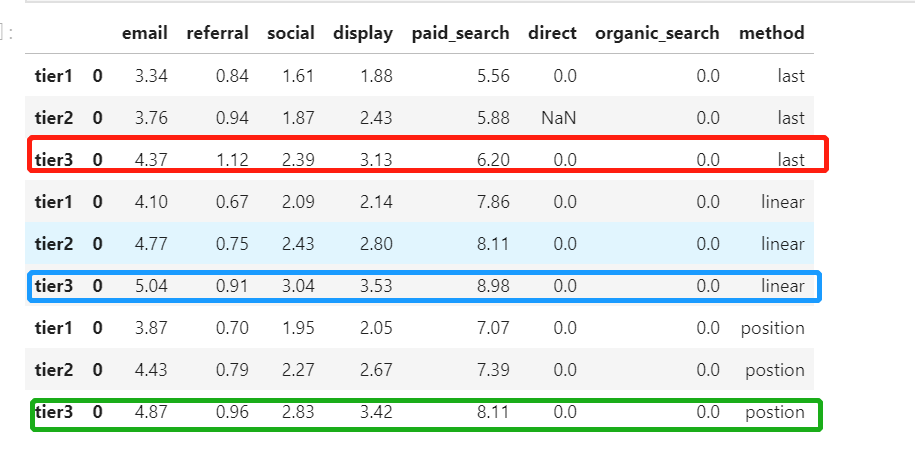

## 1.3 Conclusion
1. In a holistic view, the average CAC for each channel rises as each tier's expense increases.
2. Within each tier, the last interaction method has the lowest CAC in all channels except referral.
3. Within each tier, the linear model generates the highest CAC for each channel except referral.
4. Last interaction is the optimal choice when the corporation aims to minimize the costs.


# 2 allocaiton

## 2.1 New conclusions
1. The marginal CAC for the last interaction keeps increasing.
2. However, the marginal number of reached customers has a diminishing return as total expense increases by each layer.
3. The next 1000 dollars may not be as valuable as the previous one within each channel.
4. Some customers are easy to reach out to, but others may not.
5. Finally, a considerable expense may obtain a tiny group of customers or, even worse, no customers.

## 2.2 Choose one 

Choose one of the allocation methods and determine how you would spend an ad budget of $11,000 for next week in one target market.

In [51]:
# Here, we choose last interaciton method 
mdf  =  last.copy()

In [52]:
count1 = pd.DataFrame([tier1_count])
count2 = pd.DataFrame([tier2_count])
count3 = pd.DataFrame([tier3_count])
frames_count = [count1, count2, count3]
count_df = pd.concat(frames_count, keys=['tier1', 'tier2', 'tier3'])
col_names = count_df.columns.values.tolist()
col_names

['referral',
 'email',
 'social',
 'display',
 'paid_search',
 'organic_search',
 'direct']

In [53]:
count_df.drop(columns = ['organic_search','direct'], inplace = True)
count_df

,,referral,email,social,display,paid_search
tier1,0,1187,299,622,531,180
tier2,0,2124,532,1069,824,340
tier3,0,2670,686,1256,959,484


In [54]:
diff_count = count_df.diff()
diff_count

,,referral,email,social,display,paid_search
tier1,0,NaN,NaN,NaN,NaN,NaN
tier2,0,937.0,233.0,447.0,293.0,160.0
tier3,0,546.0,154.0,187.0,135.0,144.0


In [55]:
marginal_count = count_df.iloc[[0]].append(diff_count.iloc[1:3])
marginal_count['marginal spend'] = [1000, 1000, 1000]

In [56]:
marginal_count

,,referral,email,social,display,paid_search,marginal spend
tier1,0,1187.0,299.0,622.0,531.0,180.0,1000
tier2,0,937.0,233.0,447.0,293.0,160.0,1000
tier3,0,546.0,154.0,187.0,135.0,144.0,1000


In [57]:
names = marginal_count.columns.tolist()
marginal_cac_names = ['referral_mc', 'email_mc', 'social_mc', 'display_mc', 'paid_search_mc']

In [58]:
def marginal_cac(df):
    my_dict = {}
    cols = df.columns.tolist()
    for i in range(5):
            lst = []
            for x in range(3):
                lst.append(round(1000/df.iloc[x,i], 2))
            my_dict[cols[i]] = lst
    return pd.DataFrame(my_dict, index = marginal_count.index)
marginal_cac = marginal_cac(marginal_count)  
marginal_cac

,,referral,email,social,display,paid_search
tier1,0,0.84,3.34,1.61,1.88,5.56
tier2,0,1.07,4.29,2.24,3.41,6.25
tier3,0,1.83,6.49,5.35,7.41,6.94


In [59]:
marginal_cac = marginal_cac.rename(columns = {'referral': 'referral_mc', 'email':'email_mc', 'social':'social_mc','display':'display_mc','paid_search':'paid_search_mc'})

In [60]:
marginal_cac

,,referral_mc,email_mc,social_mc,display_mc,paid_search_mc
tier1,0,0.84,3.34,1.61,1.88,5.56
tier2,0,1.07,4.29,2.24,3.41,6.25
tier3,0,1.83,6.49,5.35,7.41,6.94


In [61]:
marginal_count

,,referral,email,social,display,paid_search,marginal spend
tier1,0,1187.0,299.0,622.0,531.0,180.0,1000
tier2,0,937.0,233.0,447.0,293.0,160.0,1000
tier3,0,546.0,154.0,187.0,135.0,144.0,1000


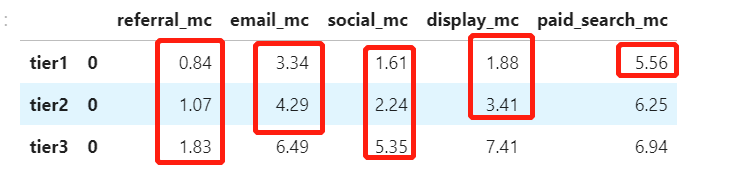

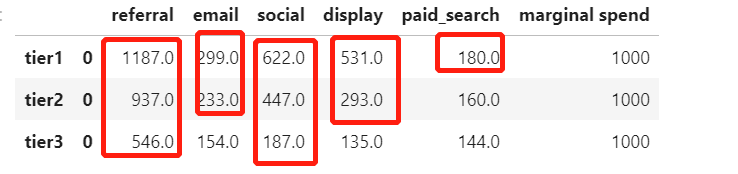